# M3_Week 1_Assignment
- Marc Pérez Quintana  <br>
- Basem Elbarashy <br>
- Sergi Garcia Bordils <br>


In [1]:
import cv2
import numpy as np
import pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier

## read the train and test files

In [2]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

## set the parameters of the execution

In [3]:
num_features = 300 #number of features for the SIFT detector but for densesift it depends on step value
k = 300 # codebook size / number of clusters for KMeans
num_neighbors = 10 #number of neighbors (k) for the k-nn classifier
knn_metric = 'manhattan'#distance for the k-nn classifier
denseSift = True #True if Dense SIFT is to be used, False for classical SIFT

## create a SIFT object detector and descriptor

In [4]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(num_features)

## implementing dense sift
- compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [5]:
Train_descriptors = []
Train_label_per_descriptor = []


for filename, labels in zip(train_images_filenames, train_labels):
    filename = filename.replace("../../Databases/MIT_split", ".")
    ima = cv2.imread(filename)
    gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
 
    if denseSift:
        step = 10
        height, width = gray.shape
        kpt = [cv2.KeyPoint(x, y, step) for y in range(0, gray.shape[0], step) 
                                        for x in range(0, gray.shape[1], step)]
        _, des = SIFTdetector.compute(gray, kpt)
        
    else:
        kpt, des = SIFTdetector.detectAndCompute(gray, None)

    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D = np.vstack(Train_descriptors)

In [6]:
print(len(kpt))

676


## compute k-means clustering on the descriptor space

In [7]:
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=6000, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=300, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

### for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [8]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

## build a k-nn classifier and train it with the train descriptors

In [9]:
knn = KNeighborsClassifier(n_neighbors=num_neighbors,n_jobs=-1,metric=knn_metric)
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')

## compute the test descriptors and compute the accuracy of the model

In [10]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    filename = filename.replace("../../Databases/MIT_split", ".")
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
         
    if denseSift:
        step = 10
        height, width = gray.shape
        kpt = [cv2.KeyPoint(x, y, step) for y in range(0, gray.shape[0], step) 
                                       for x in range(0, gray.shape[1], step)]
        _, des = SIFTdetector.compute(gray, kpt)
    else:
        kpt, des = SIFTdetector.detectAndCompute(gray, None)
        
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [11]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

81.16480793060718


We save a log file of the execution

In [12]:
with open('parameters_execution.log', 'a') as f:
    f.write('denseSift: '+str(denseSift)+', '+
            'num_features: '+str(num_features)+', '+
            'k: '+str(k)+', '+
            'num_neighbors: '+str(num_neighbors)+', '+
            'knn_metric: '+str(knn_metric)+', '+
            'accuracy: '+str(accuracy)+'\n')

## We tuned parameters individually first and then tuned all at the same time
### visualizing how each parameter affect the accuracy after trying several values for each one

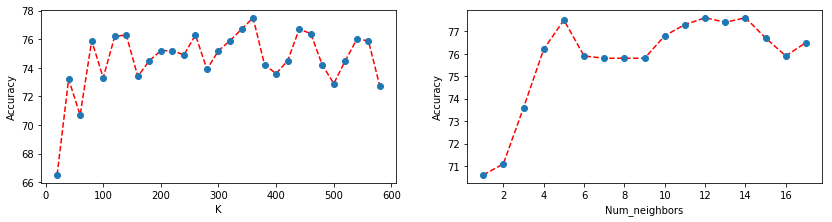

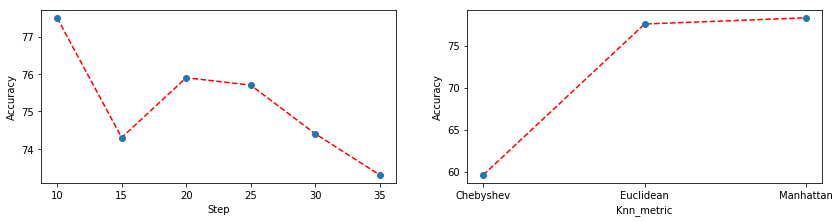

In [14]:
import numpy as np
import matplotlib.pyplot as plt


k_range             = np.arange(20, 600, 20)
num_neighbors_range = np.arange(1, 18, 1)
step_range          = np.arange(10,40,5)
knn_metric_range    = ['Chebyshev','Euclidean','Manhattan']

k_acc               = [66.5,73.2,70.7,75.9,73.3,76.2,76.3,73.4,74.5,75.2,75.2,74.9,76.3,73.9,75.2,75.9,76.7,77.5,74.2,73.6,74.5,76.7,76.4,74.2,72.9,74.5,76.0, 75.9, 72.7]
num_neighbors_acc   = [70.6,71.1,73.6,76.2,77.5,75.9,75.8,75.8,75.8,76.8,77.3,77.6,77.4,77.6,76.7,75.9, 76.5]
step_acc            = [77.5, 74.3, 75.9, 75.7, 74.4, 73.3]
knn_metric_acc      = [59.60,77.57, 78.31]

plt.figure(figsize=(14, 7))
plt.subplot(221)
plt.plot(k_range, k_acc, 'r--');  plt.plot(k_range, k_acc, 'o');  
plt.xlabel('K');  plt.ylabel('Accuracy');

plt.subplot(222)
plt.plot(num_neighbors_range, num_neighbors_acc, 'r--');  plt.plot(num_neighbors_range, num_neighbors_acc, 'o');  
plt.xlabel('Num_neighbors');  plt.ylabel('Accuracy');


plt.figure(figsize=(14, 7))
plt.subplot(221)
plt.plot(step_range, step_acc, 'r--');  plt.plot(step_range, step_acc, 'o');  
plt.xlabel('Step');  plt.ylabel('Accuracy');


plt.subplot(222)
plt.plot(knn_metric_range, knn_metric_acc, 'r--');  plt.plot(knn_metric_range, knn_metric_acc, 'o');  
plt.xlabel('Knn_metric');  plt.ylabel('Accuracy');


### Tuning all parameters at the same time, visualizing the accuracy versus deferennt configurations of parameters 


    
| denseSift | num_features   | k | num_neighbors | knn_metric | step | accuracy |
|------|------|------|------|------|------|------|
|   True  | 676 | 100  | 5 | manhattan  | 10 | 77.3  | 
|   True  | 676 | 100  | 5 | euclidean  | 10 | 73.3  | 
|   True  | 169 | 100  | 5 | manhattan  | 20 | 74.3  | 
|   True  | 169 | 100  | 5 | euclidean  | 20 | 74.3  | 
|   True  | 676 | 100  | 10 | manhattan  | 10 | 77.6  | 
|   True  | 676 | 100  | 10 | euclidean  | 10 | 74.9  | 
|   True  | 169 | 100  | 10 | manhattan  | 20 | 75.4  | 
|   True  | 169 | 100  | 10 | euclidean  | 20 | 74.5  | 
|   True  | 676 | 300  | 5 | manhattan  | 10 | 80.9  | 
|   True  | 676 | 300  | 5 | euclidean  | 10 | 75.2  | 
|   True  | 169 | 300  | 5 | manhattan  | 20 | 77.1  | 
|   True  | 169 | 300  | 5 | euclidean  | 20 | 75.9  | 
|   True  | 676 | 300  | 10 | manhattan  | 10 | 80.5  | 
|   True  | 676 | 300  | 10 | euclidean  | 10 | 75.3  | 
|   True  | 169 | 300  | 10 | manhattan  | 20 | 77.1  | 
|   True  | 169 | 300  | 10 | euclidean  | 20 | 76.4  | 
|   True  | 2704 | 300  | 10 | manhattan  | 5 | 80.7  | 
|   False  | 500 | 300  | 5 | manhattan  | - | 48.3  | 
|   False  | 800 | 300  | 5 | manhattan  | - | 52  | 

